In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [6]:
file = open("../../data/features/2019_05_07_all_features.pickle",'rb')
df = pickle.load(file, encoding='utf-8')


In [7]:
df.shape

(854, 29)

In [8]:
print(df.isnull().sum())

id                  0
Datetime            0
text                0
sentiment           0
subjectivity        0
retweets            0
favorites           0
isreply             0
year                0
month               0
day                 0
date                0
DayofWeek           0
Weekend             0
Time                0
BinaryTrading       0
DayDistance         0
Hour                0
Time_Difference     0
gtrend              0
countComment        0
posCommentAmount    0
negCommentAmount    0
neuCommentAmount    0
posCommentSum       0
negCommentSum       0
CommentSD           0
posCommentSD        0
negCommentSD        0
dtype: int64


In [10]:
df.columns

Index(['id', 'Datetime', 'text', 'sentiment', 'subjectivity', 'retweets',
       'favorites', 'isreply', 'year', 'month', 'day', 'date', 'DayofWeek',
       'Weekend', 'Time', 'BinaryTrading', 'DayDistance', 'Hour',
       'Time_Difference', 'gtrend', 'countComment', 'posCommentAmount',
       'negCommentAmount', 'neuCommentAmount', 'posCommentSum',
       'negCommentSum', 'CommentSD', 'posCommentSD', 'negCommentSD'],
      dtype='object')

In [14]:
# drop one observation with NaN 'employer_yr_established'
# df = df[np.isfinite(df['That_hour_residual'])]
df = df.drop(['emoji','replyto','That_hour_residual','That_hour_volume_perc'],1)


In [15]:
df[['origin_x','origin_y']].head()

,origin_x,origin_y
0,1.117554e+18,1117553530615648256
1,1.116887e+18,1116886883903078401
2,1.117510e+18,1117510077030834176
3,1.116887e+18,1116886883903078401
4,1.117443e+18,1117442574615183362


In [16]:
df['Time_Difference'].describe()

count     590.000000
mean     2017.520339
std         1.070722
min      2015.000000
25%      2017.000000
50%      2018.000000
75%      2018.000000
max      2019.000000
Name: Time_Difference, dtype: float64

In [17]:
df.columns

Index(['id', 'Datetime', 'text', 'sentiment', 'subjectivity', 'retweets',
       'favorites', 'isreply', 'origin_x', 'year', 'month', 'day', 'date',
       'DayofWeek', 'Weekend', 'Time', 'TradingHour', 'DayDistance',
       'Time_Difference', 'gtrend', 'origin_y', 'countComment',
       'posCommentAmount', 'negCommentAmount', 'neuCommentAmount',
       'posCommentSum', 'negCommentSum', 'CommentSD', 'posCommentSD',
       'negCommentSD', 'That_hour_volume'],
      dtype='object')

In [21]:
# prepare X and Y

X = df[['sentiment', 'subjectivity','retweets','favorites','isreply',
        'DayofWeek', 'Weekend', 'TradingHour', 'DayDistance', 
        'year','month','day',
        'gtrend', 
        'countComment', 'CommentSD', 'neuCommentAmount',
        'posCommentAmount', 'posCommentSum', 'posCommentSD',
        'negCommentAmount', 'negCommentSum',  'negCommentSD']]

Y = df[['That_hour_volume']]

In [22]:
num_features = len(X.columns)

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=100)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(531, 22) (531, 1)
(59, 22) (59, 1)


### 1. Linear Regression

In [24]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

print("Linear Reg R^2 training is: {}".format(linear_reg.score(X_train, Y_train)))

print("Linear Reg Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, linear_reg.predict(X_train)))))
print("Linear Reg Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, linear_reg.predict(X_test)))))

Linear Reg R^2 training is: 0.2941033674471374
Linear Reg Train RMSE is: 1246746.4304367844
Linear Reg Test RMSE is: 1554823.4531843362


### 2a. Simple Random Forest

In [25]:
# Random Forest
random_forest = RandomForestRegressor(n_estimators=100)     # instantiate
random_forest.fit(X_train, Y_train)                         # fit

print("Random Forest R^2 training is: {}".format(random_forest.score(X_train, Y_train)))                

print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, random_forest.predict(X_train)))))
print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, random_forest.predict(X_test)))))

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest R^2 training is: 0.8935932052326814
Random Forest Train RMSE is: 484052.26773776766
Random Forest Test RMSE is: 1622729.2427594615


### 2b. Random Forest with Cross Validation

In [26]:
rf_cv = RandomForestRegressor(n_estimators=1000, max_depth=70, max_features=np.sqrt(num_features), random_state=10)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = [10, 20, 30]
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]

# create the hyperparameter grid
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth}

print(hyperparam_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': [10, 20, 30], 'max_depth': [10, 20, 30, 40, 50]}


In [29]:
rf_grid = GridSearchCV(estimator = rf_cv, 
                       param_grid = hyperparam_grid,
                       cv = 5,
                       verbose=2,
                       n_jobs = -1)

# fit the grid search model
rf_grid.fit(X_train, Y_train)



Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] max_depth=10, max_features=10, n_estimators=200 .................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.7s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.8s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.7s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.8s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   0.9s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.2s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.2s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   1.1s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   1.5s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.8s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.8s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.9s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.8s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=   1.9s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   0.6s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   1.2s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.9s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=   1.8s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.8s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=   2.4s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=   3.0s
[CV] max_depth=10, max_features=30, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: max_features must be in (0, n_features]

In [42]:
# use optimal hyperparameters
rf_cv = RandomForestRegressor(n_estimators=1550, max_depth=70, max_features=5, random_state=10)
rf_cv.fit(X_train, Y_train)                         # fit

print("Random Forest R^2 training is: {}".format(rf_cv.score(X_train, Y_train)))                

print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, rf_cv.predict(X_train)))))
print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, rf_cv.predict(X_test)))))

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest R^2 training is: 0.9038870019890987
Random Forest Train RMSE is: 460043.22630251385
Random Forest Test RMSE is: 1556395.2772794364


In [179]:
modellist = [linear_reg, rf_cv]
modelname = ['log','rf']  

boot = [20,50,100,500]
from sklearn.metrics import mean_absolute_error

bootstrap = pd.DataFrame(columns=['size','model','mean','sd','CI','LB','UB'])
err = pd.DataFrame(columns=['size','model','mse'])
for n in boot:
    errors   = np.zeros((n, len(modellist)))
    
    for b in range(0,n):
        for i,model in enumerate(modellist):
            index = np.random.choice(list(range(0,len(X_test))),len(X_test), replace=True)
            errors[b,i] = mean_absolute_error(Y_test.iloc[index], model.predict(X_test.iloc[index]))
            err = err.append(pd.DataFrame([{'size': n, 'model' : modelname[i],'mse' : errors[b,i]  }])) 
            
    bootstrapres = pd.DataFrame({'size': n, 'model' : modelname,'mean' : errors.mean(axis=0) ,'sd' : np.std(errors, axis=0)})
#     print(bootstrapres)
    bootstrapres['CI'] = [ 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['LB'] = [b[2] - 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['UB'] = [b[2] + 1.96* b[3] for _,b in bootstrapres.iterrows()]
    
    bootstrap = bootstrap.append(bootstrapres) 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


  size model        mean         sd         CI         LB          UB
0   20   log 1013458.111 184604.811 361825.430 651632.680 1375283.541
1   20    rf  872625.023 159908.250 313420.171 559204.852 1186045.194
0   50   log  927412.349 149390.318 292805.022 634607.327 1220217.371
1   50    rf  877363.482 180180.186 353153.165 524210.317 1230516.646
0  100   log  936902.883 158761.537 311172.613 625730.270 1248075.496
1  100    rf  885303.883 167808.133 328903.940 556399.942 1214207.823
0  500   log  935855.347 149253.335 292536.537 643318.810 1228391.884
1  500    rf  869789.388 162919.980 319323.162 550466.227 1189112.550


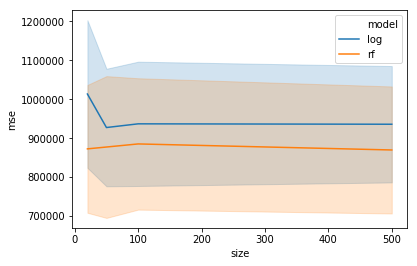

In [180]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(bootstrap)
import seaborn as sns
ax = sns.lineplot(x="size", y="mse",
             hue="model",ci='sd', 
             data=err)
# ax.fill_between(bootstrap.size, bootstrap.LB, bootstrap.UB, color='#888888', alpha=0.2)

plt.show()

1. Remove all unnecessary features and save df
2. Transform emoji to be processable
3. Remove NaN values